In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Study 2 debate

In [2]:

bahav_data_dir = '/Users/li/Desktop/task-debate/behavdata'

sub_list_num = list(range(13,51))
sub_list_num.remove(21)

time_points = [0, 252, 500, 772, 1098, 1484, 1892, 2464, 2986] # every speaker

all_subject_data = []
for sub in sub_list_num:
    file_path = os.path.join(bahav_data_dir, 'during_scan', 'combined_6runs_per_TR_filter', f'subject_{sub}_TR_rate.csv')
    df = pd.read_csv(file_path)
    sub_data = df[df['time'].isin(time_points)]
    all_subject_data.append(list(sub_data['rate']))
attitude = pd.DataFrame(all_subject_data)

attitude_change = attitude.diff(axis=1)
attitude_change = attitude_change.drop(attitude_change.columns[0], axis=1)
attitude_change.head()


,1,2,3,4,5,6,7,8
0,0,1,0,1,-5,4,-1,1
1,0,1,0,2,0,0,0,0
2,-1,2,-1,2,-4,8,-8,2
3,0,1,-1,0,-2,2,-2,1
4,2,3,-3,5,-6,8,-7,6


In [9]:
abs_ac = np.abs(attitude_change)

abs_ac_df = pd.DataFrame(abs_ac)

# 每列单独输出统计信息
for col in abs_ac_df.columns:
    print(f"Speaker {col}:")
    print(abs_ac_df[col].describe())
    print()  # 空行分隔

Speaker 1:
count    37.000000
mean      0.621622
std       0.981817
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       4.000000
Name: 1, dtype: float64

Speaker 2:
count    37.000000
mean      1.378378
std       1.209944
min       0.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       6.000000
Name: 2, dtype: float64

Speaker 3:
count    37.000000
mean      1.891892
std       2.157465
min       0.000000
25%       0.000000
50%       1.000000
75%       3.000000
max       8.000000
Name: 3, dtype: float64

Speaker 4:
count    37.000000
mean      2.351351
std       2.440585
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       9.000000
Name: 4, dtype: float64

Speaker 5:
count    37.000000
mean      3.189189
std       2.747098
min       0.000000
25%       1.000000
50%       3.000000
75%       5.000000
max      11.000000
Name: 5, dtype: float64

Speaker 6:
count    37.000000
mean      3.297297
std       2

In [19]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

# 假设你的数据是一个二维数组 abs_ac (subjects × timepoints/columns)
# abs_ac = np.array(...) 

# 初始化结果列表
t_vals = []
p_vals = []

# 对每一列做单样本 t 检验（H1: 均值 > 0）
for i in range(abs_ac.shape[1]):
    t_stat, p = ttest_1samp(abs_ac.iloc[:, i], popmean=0)
    # 因为是单尾检验大于 0，所以将双尾 p 值除以 2 并检查 t 值方向
    if t_stat > 0:
        p = p / 2
    else:
        p = 1.0  # 如果 t < 0，不考虑为显著大于 0
    t_vals.append(t_stat)
    p_vals.append(p)

# FDR 校正
rejected, p_vals_fdr = fdrcorrection(p_vals, alpha=0.05)

# 整理结果为 DataFrame
results_df = pd.DataFrame({
    'Column': np.arange(abs_ac.shape[1]),
    't_value': t_vals,
    'p_value': p_vals,
    'p_fdr': p_vals_fdr,
    'significant': rejected
})

# 打印前几行看一下
results_df


,Column,t_value,p_value,p_fdr,significant
0,0,3.851204,2.321607e-04,2.321607e-04,True
1,1,6.929535,2.031068e-08,5.416181e-08,True
2,2,5.334005,2.698206e-06,3.299019e-06,True
3,3,5.860361,5.339780e-07,8.543647e-07,True
4,4,7.061663,1.362709e-08,5.416181e-08,True
5,5,7.221028,8.437291e-09,5.416181e-08,True
6,6,5.933504,4.263479e-07,8.526957e-07,True
7,7,5.312036,2.886642e-06,3.299019e-06,True


In [17]:
abs_ac = np.abs(attitude_change)

from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

# 数据准备：将 df 变成长格式
df_long = abs_ac.melt(var_name='Variable', value_name='Value')

# 单样本 t 检验（每列 vs 0）
p_vals = [ttest_1samp(abs_ac[col], 0, alternative='greater').pvalue for col in abs_ac.columns]
_, p_fdr = fdrcorrection(p_vals)

# 显著性标记
sig_labels = []
for p in p_fdr:
    if p < 0.001:
        sig_labels.append('***')
    elif p < 0.01:
        sig_labels.append('**')
    elif p < 0.05:
        sig_labels.append('*')
    else:
        sig_labels.append('')

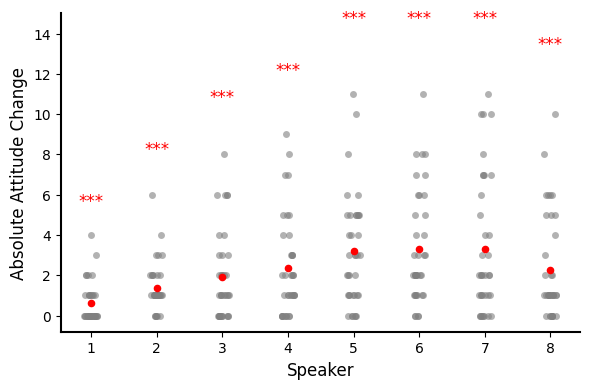

In [19]:
group_max = df_long.groupby('Variable')['Value'].max()

# 计算每个变量的平均值
mean_values = df_long.groupby('Variable')['Value'].mean()

plt.figure(figsize=(6, 4))

# 云雨图
sns.stripplot(x='Variable', y='Value', data=df_long, s= 5, jitter=True, color='gray', alpha=0.6)

# 添加平均值红点
for i, (var, mean) in enumerate(mean_values.items()):
    plt.scatter(i, mean, color='red', s=20, zorder=10)  # s 是点大小，zorder 保证点在上层

# 添加显著性标注
for i, (var, y_max) in enumerate(group_max.items()):
    if sig_labels[i]:
        plt.text(i, y_max * 1.3, sig_labels[i], ha='center', va='bottom', color='red', fontsize=12)

# plt.axhline(0, linestyle='--', color='black', linewidth=1)
# plt.title("Dot Plot with Group Means and FDR-corrected Significance")

plt.gca().set_facecolor('white')  # 背景设置为白色
plt.gca().spines['top'].set_visible(False)  # 去掉上框线
plt.gca().spines['right'].set_visible(False)  # 去掉右框线
plt.gca().spines['left'].set_linewidth(1.5)  # 设置左框线宽度
plt.gca().spines['bottom'].set_linewidth(1.5)  # 设置下框线宽度
plt.gca().grid(False)  # 关闭网格线
plt.ylim(-0.8, 15)  # 根据你的数据范围修改
plt.xlabel("Speaker", fontsize=12)
plt.ylabel("Absolute Attitude Change", fontsize=12)
plt.tight_layout()
plt.savefig(f"/Users/li/Desktop/debate2025/Figures/Absolute Attitude Change debate.png", dpi=300, bbox_inches='tight')
plt.show()


# Study 1 persuade

In [21]:

subs_change = pd.read_csv('/Users/li/Desktop/task-persuade/behavdata/subs_attitude_change.csv')
subs_change.head()
subs_change = subs_change.iloc[:, 1:]
subs_change.columns = [i for i in range(1, 16)]
subs_change.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,3,-2,-6,-3,3,-3,3,3,-6,-1,-1,2,3,2,6
1,1,-2,-4,-8,0,-4,3,7,-6,-1,-2,2,2,4,1
2,2,-1,-4,0,1,0,2,7,-2,-3,-2,2,1,0,2
3,1,3,-3,-2,6,-6,1,7,-2,-6,-6,2,5,6,1
4,5,0,-2,-1,6,-5,6,6,-4,-2,-2,1,4,5,3


In [27]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

abs_ac = np.abs(subs_change)

# 初始化列表
means, stds, mins, maxs, medians = [], [], [], [], []
t_vals, p_vals = [], []

# 逐列处理
for i in range(abs_ac.shape[1]):
    col = abs_ac.iloc[:, i]
    
    means.append(np.mean(col))
    stds.append(np.std(col, ddof=1))
    mins.append(np.min(col))
    maxs.append(np.max(col))
    medians.append(np.median(col))
    
    t_stat, p_val = ttest_1samp(col, popmean=0)
    
    # 单尾 p 值（是否显著大于0）
    p_val = p_val / 2 if t_stat > 0 else 1.0
    
    t_vals.append(t_stat)
    p_vals.append(p_val)

# FDR 校正
rejects, p_fdrs = fdrcorrection(p_vals, alpha=0.05)

# 整理成 DataFrame
results_df = pd.DataFrame({
    'Column': np.arange(abs_ac.shape[1]),
    'Mean': means,
    'Median': medians,
    'Std': stds,
    'Min': mins,
    'Max': maxs,
    't_value': t_vals,
    'p_value': p_vals,
    'p_fdr': p_fdrs,
    'Significant (FDR)': rejects
})

results_df


,Column,Mean,Median,Std,Min,Max,t_value,p_value,p_fdr,Significant (FDR)
0,0,2.628571,2.0,2.389754,0,10,6.507297,9.519700e-08,2.855910e-07,True
1,1,1.285714,1.0,1.202239,0,5,6.326853,1.625780e-07,3.483814e-07,True
2,2,3.342857,2.0,3.226206,0,12,6.129990,2.921355e-07,4.868924e-07,True
3,3,1.971429,1.0,2.036227,0,8,5.727815,9.721312e-07,1.121690e-06,True
4,4,2.400000,2.0,1.666274,0,6,8.521160,2.967954e-10,3.175993e-09,True
5,5,2.257143,1.0,2.266675,0,8,5.891201,5.961219e-07,8.128935e-07,True
6,6,2.485714,2.0,2.513159,0,11,5.851475,6.713514e-07,8.391893e-07,True
7,7,3.028571,2.0,2.791644,0,9,6.418178,1.239679e-07,3.099197e-07,True
8,8,3.028571,3.0,2.134943,0,9,8.392387,4.234658e-10,3.175993e-09,True
9,9,1.914286,2.0,1.915439,0,7,5.912517,5.593045e-07,8.128935e-07,True


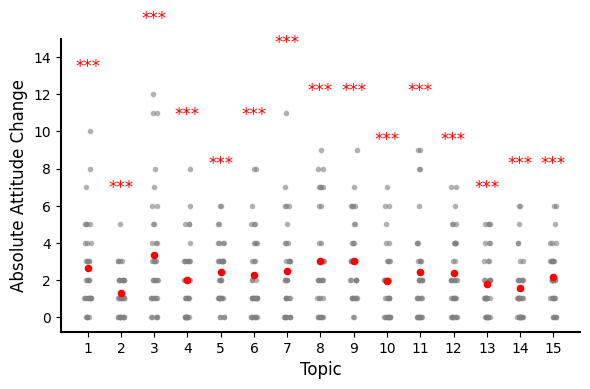

In [39]:
abs_ac = np.abs(subs_change)

from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

# 数据准备：将 df 变成长格式
df_long = abs_ac.melt(var_name='Variable', value_name='Value')

# 单样本 t 检验（每列 vs 0）
p_vals = [ttest_1samp(abs_ac[col], 0, alternative='greater').pvalue for col in abs_ac.columns]
_, p_fdr = fdrcorrection(p_vals)

# 显著性标记
sig_labels = []
for p in p_fdr:
    if p < 0.001:
        sig_labels.append('***')
    elif p < 0.01:
        sig_labels.append('**')
    elif p < 0.05:
        sig_labels.append('*')
    else:
        sig_labels.append('')
        
group_max = df_long.groupby('Variable')['Value'].max()

# 计算每个变量的平均值
mean_values = df_long.groupby('Variable')['Value'].mean()

plt.figure(figsize=(6, 4))

# 云雨图
sns.stripplot(x='Variable', y='Value', data=df_long, s= 4, jitter=True, color='gray', alpha=0.6)

# 添加平均值红点
for i, (var, mean) in enumerate(mean_values.items()):
    plt.scatter(i, mean, color='red', s=20, zorder=10)  # s 是点大小，zorder 保证点在上层

# 添加显著性标注
for i, (var, y_max) in enumerate(group_max.items()):
    if sig_labels[i]:
        plt.text(i, y_max * 1.3, sig_labels[i], ha='center', va='bottom', color='red', fontsize=12)

plt.gca().set_facecolor('white')  # 背景设置为白色
plt.gca().spines['top'].set_visible(False)  # 去掉上框线
plt.gca().spines['right'].set_visible(False)  # 去掉右框线
plt.gca().spines['left'].set_linewidth(1.5)  # 设置左框线宽度
plt.gca().spines['bottom'].set_linewidth(1.5)  # 设置下框线宽度
plt.gca().grid(False)  # 关闭网格线
plt.ylim(-0.8, 15)  # 根据你的数据范围修改
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Absolute Attitude Change", fontsize=12)
plt.tight_layout()
plt.savefig(f"/Users/li/Desktop/debate2025/Figures/Absolute Attitude Change persuade.png", dpi=300, bbox_inches='tight')
plt.show()
